# Preprocessing Training Dataset

In [1]:
import os
import sys
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

import matplotlib.pyplot as plt

2024-01-07 23:07:41.482337: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 23:07:41.510536: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 23:07:41.511264: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-07 23:07:41.980965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [35]:
INPUT_SIZE = (224, 224)
IMGS_DIR_TRAIN = "laila_images_train"
IMGS_DIR_TEST = "laila_images_test"

In [3]:
def preprocess_img(img_array):
    # Expand dimensions to fit the model input format (batch_size, height, width, channels)
    img_array = tf.expand_dims(img_array, axis=0)

    # Normalize the image
    img_array = preprocess_input(img_array)

    return img_array
    
def preprocess_imgs_directory(directory, input_size):
    processed_imgs = []
    labels = []

    for label in os.listdir(IMGS_DIR):
        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):
            image_path = os.path.join(label_dir, filename)
            if os.path.isfile(image_path):
                img = load_img(image_path, target_size=input_size)
                img_raw = img_to_array(img)
                
                img_preprocessed = preprocess_img(img_raw)
                processed_imgs.append(img_preprocessed)
                labels.append(int(label))

    processed_imgs = np.vstack(processed_imgs)
    labels = np.array(labels)

    return processed_imgs, labels

In [4]:
directory = 'laila_images'

images, labels = preprocess_imgs_directory(directory, INPUT_SIZE)

2024-01-07 23:07:46.032582: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-07 23:07:46.033343: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [70]:
images.shape

(114, 224, 224, 3)

In [5]:
data_gen = ImageDataGenerator(
    rescale=1./255,      # Normalize the image
    rotation_range=20,   # Random rotations between -20 to +20 degrees
    width_shift_range=0.2,   # Random horizontal shifts up to 20% of the image width
    height_shift_range=0.2,  # Random vertical shifts up to 20% of the image height
    shear_range=0.2,         # Shear transformations
    zoom_range=0.2,          # Random zooming
    horizontal_flip=True,    # Random horizontal flips
    fill_mode='nearest'      # Strategy to fill newly created pixels after a transformation
)

In [6]:
train_data_gen = data_gen.flow(images, labels, batch_size=32)

In [7]:
augmented_images, augmented_labels = train_data_gen.next()

## Using Flow from directory
Easier and smarter approach also using data augmentation!

In [34]:
TRAIN_IMGS_DIR

'laila_images'

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Data Augmentation
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input  # MobileNetV2 preprocessing
)

# Create the generator
train_data_gen = data_gen.flow_from_directory(
    IMGS_DIR_TRAIN,
    target_size=INPUT_SIZE,  # Resize for MobileNetV2
    batch_size=32,
    class_mode='binary'  # or 'categorical' based on your label setup
)

val_data_gen = data_gen.flow_from_directory(
    IMGS_DIR_TEST,
    target_size=INPUT_SIZE,  # Resize for MobileNetV2
    batch_size=32,
    class_mode='binary'  # or 'categorical' based on your label setup
)

Found 80 images belonging to 2 classes.
Found 41 images belonging to 2 classes.


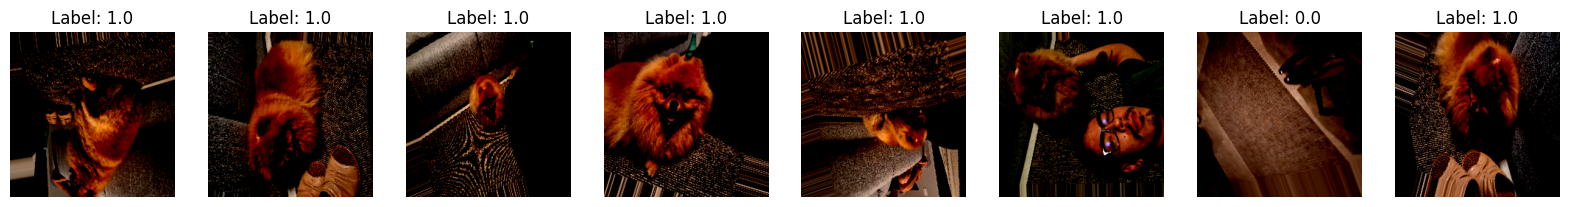

In [37]:
# Retrieve a batch of images and labels
images, labels = next(train_data_gen)

# Define the number of images you want to display (e.g., 8 images)
num_images = 8

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(1, num_images, figsize=(20, 20))

# Display the first 'num_images' images
for i in range(num_images):
    ax = axes[i]
    ax.imshow(images[i])
    ax.axis('off')
    ax.set_title(f'Label: {labels[i]}')

plt.show()

In [38]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

In [39]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(1, activation='sigmoid')  # Single neuron for binary classification
])

In [41]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
history = model.fit(
    train_data_gen,
    epochs=10,
    validation_data=val_data_gen
)

Epoch 1/10
3/3 [==============================] - 10s 4s/step - loss: 0.7768 - accuracy: 0.5500 - val_loss: 0.5741 - val_accuracy: 0.5366
Epoch 2/10
3/3 [==============================] - 7s 3s/step - loss: 0.4751 - accuracy: 0.7125 - val_loss: 0.4884 - val_accuracy: 0.5854
Epoch 3/10
3/3 [==============================] - 7s 3s/step - loss: 0.2625 - accuracy: 0.9125 - val_loss: 0.2739 - val_accuracy: 0.9756
Epoch 4/10
3/3 [==============================] - 7s 3s/step - loss: 0.1489 - accuracy: 0.9875 - val_loss: 0.1947 - val_accuracy: 0.9756
Epoch 5/10
3/3 [==============================] - 7s 3s/step - loss: 0.0994 - accuracy: 0.9875 - val_loss: 0.1690 - val_accuracy: 0.9512
Epoch 6/10
3/3 [==============================] - 7s 3s/step - loss: 0.0836 - accuracy: 0.9875 - val_loss: 0.1605 - val_accuracy: 0.9512
Epoch 7/10
3/3 [==============================] - 7s 3s/step - loss: 0.0571 - accuracy: 0.9875 - val_loss: 0.1756 - val_accuracy: 0.9512
Epoch 8/10
3/3 [========================

## Manual Testing

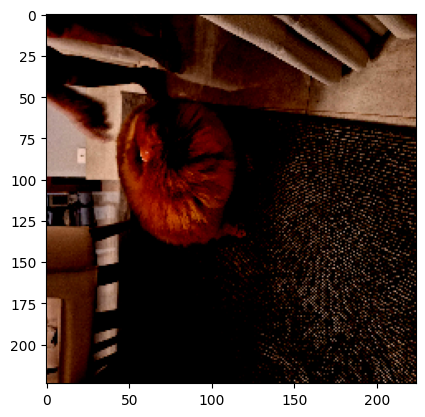

In [73]:
laila_img_path = "laila_images_test/1/20240107_193940.jpg"

laila = img_to_array(load_img(laila_img_path, target_size=INPUT_SIZE))
laila = preprocess_input(laila)
plt.imshow(laila)

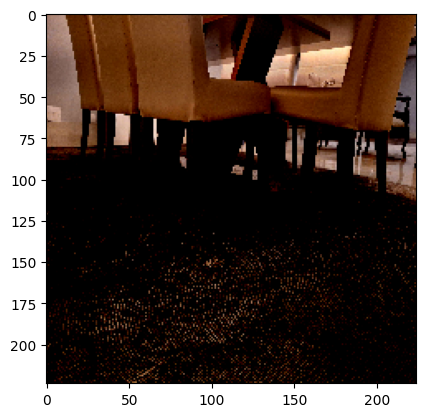

In [76]:
empty_room_img_path = "laila_images_test/0/20240106_232543.jpg"

empty_room = img_to_array(load_img(empty_room_img_path, target_size=INPUT_SIZE))
empty_room = preprocess_input(empty_room)
plt.imshow(empty_room)

In [77]:
model.predict(np.array([laila, empty_room]))

1/1 [==============================] - 0s 25ms/step


array([[0.99682474],
       [0.05410817]], dtype=float32)

Nice!!!
Laila picture has a 95% prob
Empty room has a 2% prob

In [78]:
model.save("andog18_valpha.h5")

/home/nakamaru/miniconda3/envs/andog18/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
